<a href="https://colab.research.google.com/github/skhazaei/TensorFlow-repo/blob/master/sarcasm_with_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the sarcasm dataset

In [1]:
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
-O /tmp/sarcasm.json

--2021-02-17 23:48:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-02-17 23:48:09 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



## Save the headlines and labels as a list 

In [3]:
import json

with open('/tmp/sarcasm.json',  'r') as f:
  datastore = json.load(f)

headlines=[]
labels=[]

for items in datastore:
  headlines.append(items['headline'])
  labels.append(items['is_sarcastic'])

## How large is the dataset?

In [4]:
print('Size of dataset: {}'.format(len(datastore)))

Size of dataset: 26709


## Assign the first 20,000 examples to the training set and the rest to test set

In [5]:
training_size = 20000

training_headlines = headlines[0:training_size]
training_labels = labels[0:training_size]

test_headlines = headlines[training_size:]
test_labels = labels[training_size:]

## Tokenize and padding the headlines

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 1000
oov_tok = '<OOV>'
trunc_type='post'
max_length = 120

tokenizer = Tokenizer(vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)
sequences = tokenizer.texts_to_sequences(training_headlines)

from tensorflow.keras.preprocessing.sequence import pad_sequences
## padding the sequences
padded = pad_sequences(sequences, truncating=trunc_type, maxlen=max_length)


## test sequences and padding
test_seq = tokenizer.texts_to_sequences(test_headlines)
test_pad = pad_sequences(test_seq, maxlen=max_length, truncating=trunc_type)

## Convert the padded headlines and labels to the numpy array

In [7]:
import numpy as np

padded = np.array(padded)
training_labels = np.array(training_labels)

test_pad = np.array(test_pad)
test_labels = np.array(test_labels)

## Define Conv1D model

In [9]:
import tensorflow as tf

embedding_dim = 16
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                    tf.keras.layers.Conv1D(128, 5, activation='relu'),
                                    tf.keras.layers.GlobalMaxPooling1D(),
                                    tf.keras.layers.Dense(24, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
history = model.fit(padded, training_labels, epochs=50, validation_data=(test_pad, test_labels), verbose=2)

Epoch 1/50
625/625 - 10s - loss: 0.4552 - accuracy: 0.7704 - val_loss: 0.3980 - val_accuracy: 0.8164
Epoch 2/50
625/625 - 2s - loss: 0.3466 - accuracy: 0.8443 - val_loss: 0.3955 - val_accuracy: 0.8156
Epoch 3/50
625/625 - 2s - loss: 0.3141 - accuracy: 0.8595 - val_loss: 0.3787 - val_accuracy: 0.8286
Epoch 4/50
625/625 - 2s - loss: 0.2803 - accuracy: 0.8784 - val_loss: 0.3932 - val_accuracy: 0.8255
Epoch 5/50
625/625 - 2s - loss: 0.2498 - accuracy: 0.8944 - val_loss: 0.4216 - val_accuracy: 0.8216
Epoch 6/50
625/625 - 2s - loss: 0.2180 - accuracy: 0.9124 - val_loss: 0.4549 - val_accuracy: 0.8144
Epoch 7/50
625/625 - 2s - loss: 0.1854 - accuracy: 0.9262 - val_loss: 0.4849 - val_accuracy: 0.8168
Epoch 8/50
625/625 - 2s - loss: 0.1556 - accuracy: 0.9388 - val_loss: 0.5462 - val_accuracy: 0.8152
Epoch 9/50
625/625 - 2s - loss: 0.1293 - accuracy: 0.9504 - val_loss: 0.6299 - val_accuracy: 0.8076
Epoch 10/50
625/625 - 2s - loss: 0.1073 - accuracy: 0.9610 - val_loss: 0.6742 - val_accuracy: 0.804

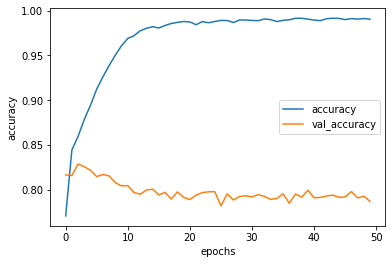

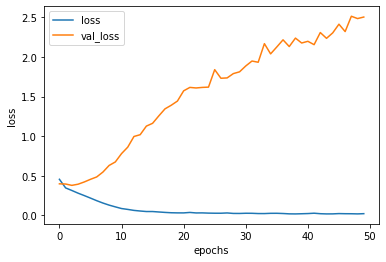

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [13]:
model.save('sarcasm_Conv1D.h5')